# Liabilty-Friendly Equity Portfolios

Equity is the biggest, most important and most liquid component of the PSP (Performance Seeking Portfolio), the question today is whether we should try and design equity portfolios with better liability hedging benefits called liability-friendly equity portfolios.

### Defining Liability Friendliness

**Intuitive approach based on a cash-flow matching focus:**

- Stocks with high and stable dividends, yields should be more attractive than average for liability-matching purposes

**Statistical approach based on a factor matching focus**

- Stocks with low volatility should be more attractive than average for liability-hedging purposes

Selecting stocks with above average liability friendliness allows investors to allocate more to equity for a given risk budget. This translates into superior performance unless liability friendly stocks strongly underperform compared to the market average.


# Lab Session -  Dynamic Risk Budgeting between PSP & LHP

In [41]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios = n_scenarios, b = 0.03, r_0 = 0.03, sigma = 0.02)
prices_eq = erk.gbm_updated(n_years = 10, n_scenarios = n_scenarios, mu = 0.07, sigma = 0.15)

In [43]:
rets_eq = prices_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator = erk.fixedmix_allocator, w1 = 0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name = "ZC", floor = 0.75),
    erk.terminal_stats(rets_eq, name = "EQ", floor = 0.75),
    erk.terminal_stats(rets_7030b, name = "70/30", floor = 0.75)
], axis = 1).round(2)

,ZC,EQ,70/30
mean,1.34,1.96,1.75
std,0.00,0.98,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.11,0.09
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [44]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator = erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:])

In [45]:
pd.concat([
    erk.terminal_stats(rets_zc, name = "ZC", floor = 0.75),
    erk.terminal_stats(rets_eq, name = "EQ", floor = 0.75),
    erk.terminal_stats(rets_7030b, name = "70/30", floor = 0.75),
    erk.terminal_stats(rets_floor75, name = "Floor75", floor = 0.75)
], axis = 1).round(2)

,ZC,EQ,70/30,Floor75
mean,1.34,1.96,1.75,1.93
std,0.00,0.98,0.59,0.99
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.11,0.09,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [46]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator = erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:], m = 1)
rets_floor75m7 = erk.bt_mix(rets_eq, rets_zc, allocator = erk.floor_allocator, floor = 0.75, zc_prices = zc_prices[1:], m = 7)

In [47]:
pd.concat([
    erk.terminal_stats(rets_zc, name = "ZC", floor = 0.75),
    erk.terminal_stats(rets_eq, name = "EQ", floor = 0.75),
    erk.terminal_stats(rets_7030b, name = "70/30", floor = 0.75),
    erk.terminal_stats(rets_floor75, name = "Floor75", floor = 0.75),
    erk.terminal_stats(rets_floor75m1, name = "Floor75m1", floor = 0.75),
    erk.terminal_stats(rets_floor75m7, name = "Floor75m7", floor = 0.75)
], axis = 1).round(2)

,ZC,EQ,70/30,Floor75,Floor75m1,Floor75m7
mean,1.34,1.96,1.75,1.93,1.62,1.94
std,0.00,0.98,0.59,0.99,0.43,0.99
p_breach,NaN,0.04,0.01,NaN,NaN,0.00
e_short,NaN,0.11,0.09,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
pd.concat([
    erk.terminal_stats(rets_zc, name = "ZC", floor = 0.75),
    erk.terminal_stats(rets_eq, name = "EQ", floor = 0.75),
    erk.terminal_stats(rets_7030b, name = "70/30", floor = 0.75),
    erk.terminal_stats(rets_floor75, name = "Floor75", floor = 0.75),
    erk.terminal_stats(rets_floor75m1, name = "Floor75m1", floor = 0.75),
    erk.terminal_stats(rets_floor75m7, name = "Floor75m7", floor = 0.75)
], axis = 1).round(5)

,ZC,EQ,70/30,Floor75,Floor75m1,Floor75m7
mean,1.34334,1.95593,1.74864,1.93147,1.61582,1.94254
std,0.00000,0.98032,0.59147,0.98607,0.43266,0.98953
p_breach,NaN,0.03660,0.00560,NaN,NaN,0.00300
e_short,NaN,0.10874,0.08556,NaN,NaN,0.00498
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


### Risk Budgeting with Drawdown Constraints 

In [49]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns = rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator = erk.drawdown_allocator, maxdd = 0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

In [50]:
pd.concat([
    erk.terminal_stats(rets_zc, name = "ZC", floor = 0.75),
    erk.terminal_stats(rets_eq, name = "EQ", floor = 0.75),
    erk.terminal_stats(rets_7030b, name = "70/30", floor = 0.75),
    erk.terminal_stats(rets_floor75, name = "Floor75", floor = 0.75),
    erk.terminal_stats(rets_floor75m1, name = "Floor75m1", floor = 0.75),
    erk.terminal_stats(rets_floor75m7, name = "Floor75m7", floor = 0.75),
    erk.terminal_stats(rets_maxdd25, name = "MaxDD25", floor = 0.75)
], axis = 1).round(5)

,ZC,EQ,70/30,Floor75,Floor75m1,Floor75m7,MaxDD25
mean,1.34334,1.95593,1.74864,1.93147,1.61582,1.94254,1.69270
std,0.00000,0.98032,0.59147,0.98607,0.43266,0.98953,0.55469
p_breach,NaN,0.03660,0.00560,NaN,NaN,0.00300,NaN
e_short,NaN,0.10874,0.08556,NaN,NaN,0.00498,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.177616
1   -0.221982
2   -0.127788
3   -0.121863
4   -0.174854
Name: Max Drawdown, dtype: float64

In [52]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.22663940758548348

In [53]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
tv_floor75m7 = erk.terminal_values(rets_floor75m7)

/Users/mog/.local/share/virtualenvs/Investment-Management-with-Python-3feIDhEi/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mog/.local/share/virtualenvs/Investment-Management-with-Python-3feIDhEi/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mog/.local/share/virtualenvs/Investment-Management-with-Python-3feIDhEi/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distp

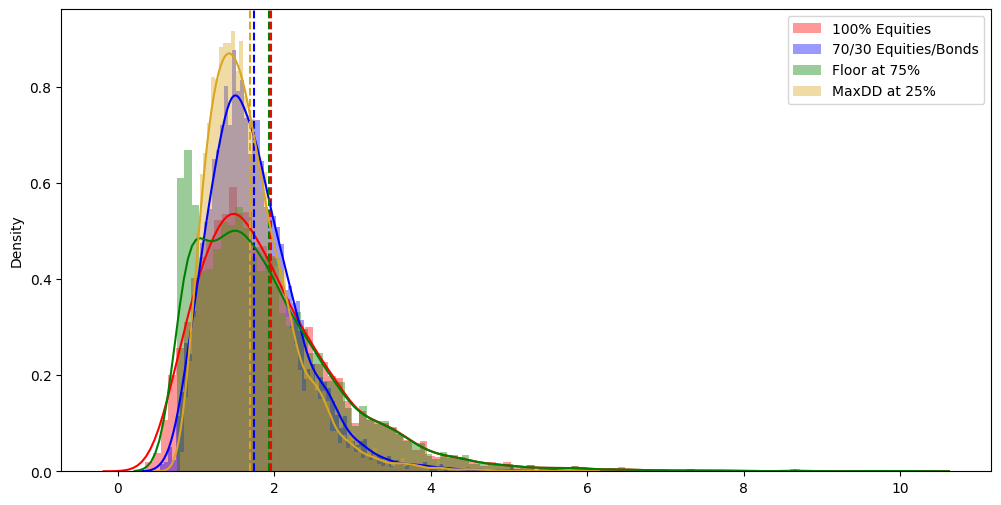

In [56]:
# plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color = "red", label = "100% Equities", bins = 100)
plt.axvline(tv_eq.mean(), ls = "--", color = "red")
sns.distplot(tv_7030b, color = "blue", label = "70/30 Equities/Bonds", bins = 100)
plt.axvline(tv_7030b.mean(), ls = "--", color = "blue")
sns.distplot(tv_floor75, color = "green", label = "Floor at 75%", bins = 100)
plt.axvline(tv_floor75.mean(), ls = "--", color = "green")
sns.distplot(tv_maxdd25, color = "goldenrod", label = "MaxDD at 25%", bins = 100)
plt.axvline(tv_maxdd25.mean(), ls = "--", color = "goldenrod")
plt.legend();

### Drawdown Constraint with Historical Data

<AxesSubplot:>

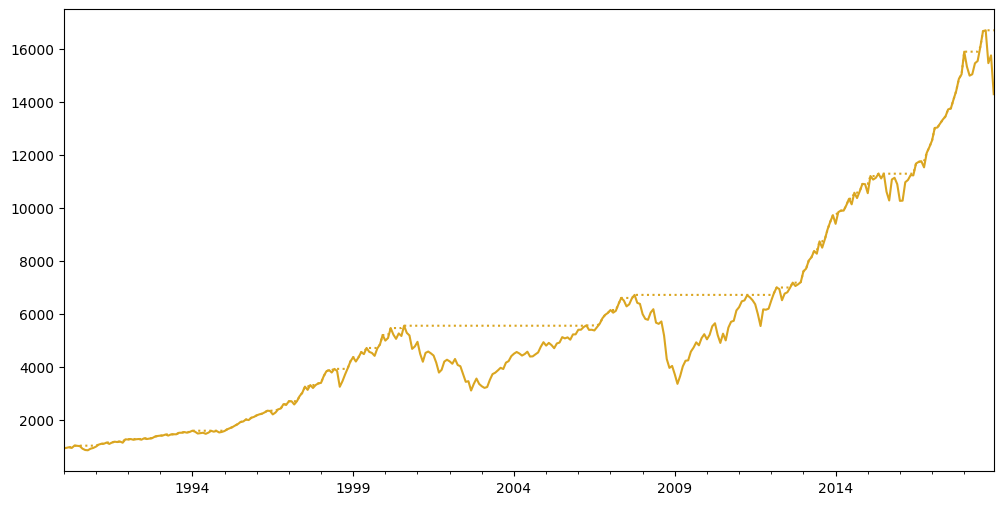

In [58]:
rets_tmi = erk.get_total_market_index_returns().loc["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12, 6), ls="-", color="goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

In [59]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_tmi.index, columns = [0])
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

<AxesSubplot:>

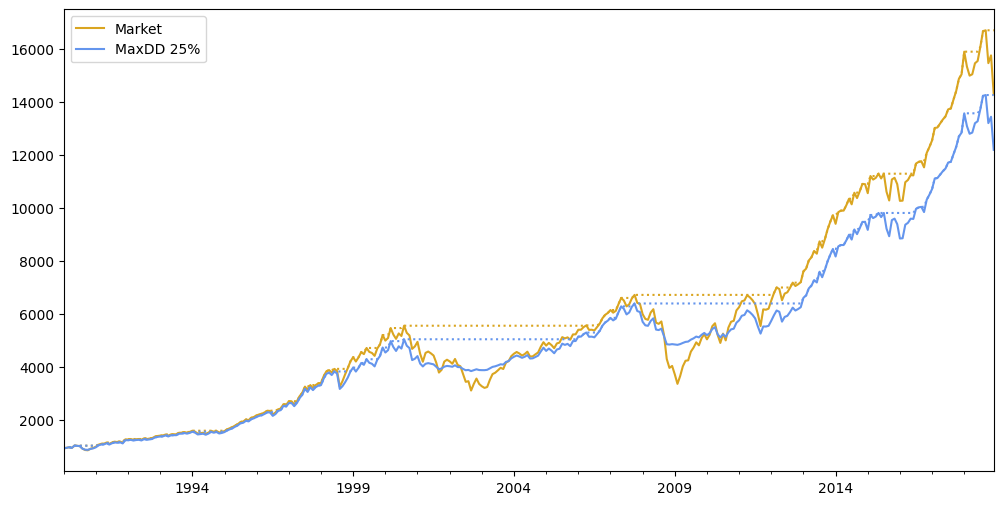

In [60]:
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls=":", color= "goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")

In [62]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis = 1))

,Annualised Return,Annualised Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.067653,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.050463,0.071074,0.518327,-0.244212
